In [53]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import requests
import nltk
import PyPDF2
from PyPDF2 import PdfFileWriter, PdfFileReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
from requests_html import HTMLSession
from collections import defaultdict
from datetime import datetime
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
listaPdfs = os.listdir('../modulo3/descargas_Pdf/')
listaPdfs[90:95]
lis_fullpath = ['../modulo3/descargas_Pdf/' + x for x in listaPdfs]
lis_fullpath[90:95]

['../modulo3/descargas_Pdf/comunicado_111419.pdf',
 '../modulo3/descargas_Pdf/comunicado_111518.pdf',
 '../modulo3/descargas_Pdf/comunicado_111716.pdf',
 '../modulo3/descargas_Pdf/comunicado_112610.pdf',
 '../modulo3/descargas_Pdf/comunicado_112709.pdf']

In [3]:
#continuar con la base creada
data = pd.read_pickle("resumen_comunicados.pkl")
data.head()

,text,url,category,cat_num
date,,,,
2020-02-13,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1
2019-12-19,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1
2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1
2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1


In [4]:
# crear funciones de lectura de pdf y limpieza de texto
def ext_texto(documento):
    with open(documento, mode='rb') as f:
        reader = PdfFileReader(f)
        for page in reader.pages:
            pass
        return page.extractText()
def limpieza(page_content):
    evitar = ["reducir","mantener","incremetar"]
    stop_words = stopwords.words('spanish')
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    
    tokens = word_tokenize(page_content)
    words = tokens
    words = [word for word in words if word.isalpha()]
    words = [w.lower() for w in words]
    words = [re_punc.sub('', w) for w in words]
    words = [w for w in words if not w in stop_words]
    words = [unidecode(w) for w in words]
    #words = [w for w in words if len(w) > 2]
    words = [w for w in words if not w in evitar]
    #words = [spa_stemmer.stem(word) for word in words]
    return words

In [5]:
data["pdf"] = ["comunicado_"+datetime.strftime(x, '%m%d%y')+".pdf" for x in data.index]

In [6]:
#agregar al DF la bolsa de palabras de cada documento
contenidos = []
for pdf in data.pdf:
    path = '../modulo3/descargas_Pdf/'+pdf
    page_content = ext_texto(path)
    cont = limpieza(page_content)
    contenidos.append(cont)
    
data["words"] = contenidos

In [7]:
data.head()

,text,url,category,cat_num,pdf,words
date,,,,,,
2020-02-13,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1,comunicado_021320.pdf,"[comunicado, prensa, febrero, anuncio, politic..."
2019-12-19,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1,comunicado_121919.pdf,"[ligeras, reducciones, ubicarse, s, expectativ..."
2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1,comunicado_111419.pdf,"[inflacion, general, octubre, destaca, subindi..."
2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1,comunicado_092619.pdf,"[reciente, mientras, mayor, plazo, perm, aneci..."
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1,comunicado_081519.pdf,"[junta, mantendra, postura, monetaria, prudent..."


In [10]:
#Crear la bolsa de palabras de cada clase y cada documento
D1 = data.loc[data.category =='disminuye',["category","words"]]
D2 = data.loc[data.category =='incrementa',["category","words"]]
D3 = data.loc[data.category =='sin cambio',["category","words"]]

In [11]:
#crear las lostas de entrenamiento y test
D1, D1_test = train_test_split(D1, test_size = 0.2)
D2, D2_test = train_test_split(D2, test_size = 0.2)
D3, D3_test = train_test_split(D3, test_size = 0.2)

In [12]:
#Nk
N1 = len(D1)
N2 = len(D2)
N3 = len(D3)
N = N1 + N2 + N3
N

82

In [14]:
#vectores de palabras por clase
V1 = []
V2 = []
V3 = []
for w in range(len(D1.words)):
    pal = D1.words[w]
    V1.extend(pal)
for w in range(len(D2.words)):
    pal = D2.words[w]
    V2.extend(pal)
for w in range(len(D3.words)):
    pal = D3.words[w]
    V3.extend(pal)

In [15]:
#tamaño de los vectores de palabras
print(len(V1),len(V2),len(V3))

3514 2736 14362


In [16]:
len(set(V1))/len(V1)

0.3016505406943654

In [17]:
len(set(V2))/len(V2)

0.3223684210526316

In [18]:
len(set(V3))/len(V3)

0.16299958223088706

In [19]:
V = set(V1) | set(V2) | set(V3)

In [20]:
vocabulario = pd.DataFrame(index=V)

In [21]:
V1_c = pd.Series(V1, name = "k1").value_counts()
V2_c = pd.Series(V2, name = "k2").value_counts()
V3_c = pd.Series(V3, name = "k3").value_counts()

In [43]:
print(V1_c[:5],V2_c[:5],V3_c[:5])

inflacion    120
monetaria     46
riesgos       40
economia      35
junta         34
Name: k1, dtype: int64 inflacion       99
monetaria       48
precios         45
expectativas    35
objetivo        35
Name: k2, dtype: int64 inflacion    507
precios      220
ciento       214
monetaria    177
objetivo     133
Name: k3, dtype: int64


In [23]:
#likelihood
L = vocabulario.join(V1_c, how = "left").join(V2_c, how = "left").join(V3_c, how = "left")
L = L.fillna(0) +1 
L = L/L.sum(axis=0)
L

,k1,k2,k3
acomodar,0.000157,0.000179,0.000116
eleva,0.000627,0.000179,0.000174
otor,0.000157,0.000179,0.000116
resintio,0.000314,0.000179,0.000058
primarios,0.000314,0.000179,0.000116
...,...,...,...
vi,0.000470,0.000179,0.000058
acionales,0.000157,0.000179,0.000116
buena,0.000157,0.000357,0.000580
vio,0.000157,0.000357,0.000290


In [51]:
log_L = np.log(L)
df_k = L.sample(10,random_state=314)
df_k

,k1,k2,k3
remento,0.000157,0.000357,0.000116
proyeccion,0.000627,0.000179,0.000116
mayo,0.000627,0.000536,0.000464
ajustadas,0.000157,0.000357,0.000058
todas,0.000314,0.000179,0.000116
gares,0.000157,0.000179,0.000116
rable,0.000157,0.000179,0.000116
observen,0.000157,0.000179,0.000174
avanzada,0.000157,0.000179,0.000174
particularment,0.000157,0.000357,0.000116


In [44]:
log_L.loc[["monetaria"]].sum(axis=0)

k1   -4.910619
k2   -4.738880
k3   -4.572450
dtype: float64

In [27]:
lo_prior_k1 = np.log(N1/N)
lo_prior_k2 = np.log(N2/N)
lo_prior_k3 = np.log(N3/N)

In [28]:
log_prior = np.array([lo_prior_k1,lo_prior_k2,lo_prior_k3])

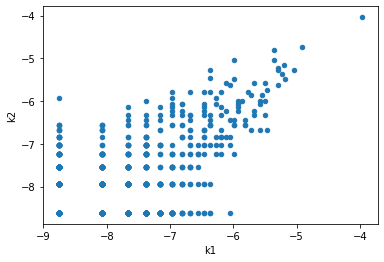

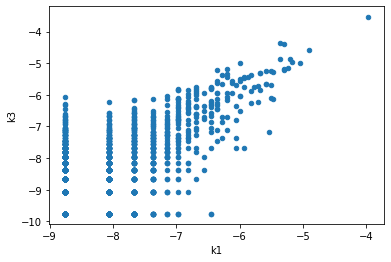

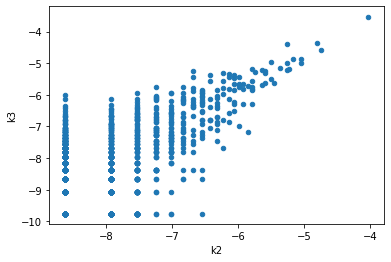

In [61]:
log_L.plot.scatter(x="k1",y="k2")
log_L.plot.scatter(x="k1",y="k3")
log_L.plot.scatter(x="k2",y="k3")

In [32]:
D1_test

,category,words
date,,
2009-06-19,disminuye,"[junio, comunicado, prensa, anuncio, politica,..."
2019-08-15,disminuye,"[junta, mantendra, postura, monetaria, prudent..."
2009-02-20,disminuye,"[febrero, comunicado, prensa, anuncio, politic..."
2009-05-15,disminuye,"[mayo, comunicado, prensa, anuncio, politica, ..."


In [34]:
log_L.loc[f].sum(axis=0) 

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike [ipykernel_launcher.py:1]


k1   -1004.130682
k2   -1083.891645
k3   -1057.315356
dtype: float64

In [62]:
res = log_L.loc[f].sum(axis=0) + log_prior
res
res.idxmax()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike [ipykernel_launcher.py:1]


'k3'

In [37]:
D_test = pd.concat([D1_test, D2_test, D3_test], axis=0)
y_test= ["k1"] * len(D1_test) + ["k2"] * len(D2_test) + ["k3"] * len(D3_test)
print(y_test)

['k1', 'k1', 'k1', 'k1', 'k2', 'k2', 'k2', 'k2', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3', 'k3']


In [38]:
yhat_test = []
for d_test in D_test.words:
    f = set(d_test)
    res = log_L.loc[f].sum(axis=0) + log_prior
    yhat_test.append(res.idxmax())

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike [ipykernel_launcher.py:4]


# Matriz de confusion
sin usar las palabras en el texto que indican aumento, disminución o mantenimeinto de la tasa

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,yhat_test)
cm

array([[ 2,  1,  1],
       [ 0,  3,  1],
       [ 2,  0, 13]], dtype=int64)

In [63]:
#Accuracy
sum(cm.diagonal())/cm.sum()

0.782608695652174

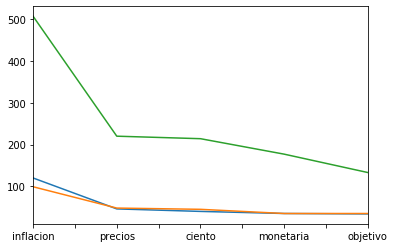

In [66]:
V1_c[:5].plot()
V2_c[:5].plot()
V3_c[:5].plot()

el accuracy se ve afectado por  aparecen en todas las clases